<a href="https://colab.research.google.com/github/mukul-mschauhan/Machine-Learning-Projects/blob/master/Vision_Transformers_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer Architecture from Scratch using Pytorch

* Imports core PyTorch + TorchVision utilities.
* ``torchvision`` is used for MNIST dataset.
* ``transforms`` will convert ``PIL images → tensors.``

* ``nn`` provides layers like ``Conv2d``, ``LayerNorm``, ``MultiheadAttention, Linear.``

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn

## Image Transformation in Tensor Format

* Converts each MNIST image to a PyTorch tensor of shape:

* **(C, H, W) = (1, 28, 28)**

* Pixel values become floats in
[
0
,
1
]
[0,1].

In [2]:
# Transformation of Image data into tensor format
transformation = transforms.Compose([transforms.ToTensor()])

## Load MNIST train split

* Downloads MNIST training data (60k images).
* Applies the transform from Cell 2

In [3]:
train_dataset = torchvision.datasets.MNIST(root = "./data", train = True,
                                          download = True,
                                          transform = transformation)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 467kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


## Load MNIST test/val split

* Loads MNIST test data (10k images).

In [4]:
val_dataset = torchvision.datasets.MNIST(root = "./data", train = False,
                                          download = True,
                                          transform = transformation)

## Hyperparameters / ViT configuration

* What each means (and why it matters)

* **img_size=28**, **patch_size=7** → patches per side = 28/7 = 4

* Total patches: **patch_num=4×4=16**

* Each patch becomes one “token” (like a word token in NLP).

* embed_dim=20 = token embedding dimension.

* attention_heads=4 means multi-head attention splits embedding into 4 heads.

* Requirement: embed_dim % heads == 0 → 20 % 4 = 0

In [6]:
# Model Parameters
batch_size = 64
num_channels = 1 # for RGB, it will be 3
num_classes = 10
img_size = 28
patch_size = 7
patch_num = (img_size // patch_size) * (img_size // patch_size)
attention_heads = 4
embed_dim = 20 # we can change to 768 later
transformer_blocks = 4
mlp_nodes = 64
num_epochs = 10
epochs = 5

## Data Loader

* Wraps datasets into mini-batches.

* shuffle=True randomizes order.

* Note: For validation/test, typically use shuffle=False (not wrong, just standard practice).

In [7]:
# Use a dataloader
import torch.utils.data as dataloader
train_data = dataloader.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_data = dataloader.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

## Patch Embedding module

* What it does (ViT step: “patchify + embed”)

* Uses Conv2d with kernel_size=stride=patch_size to:

  * cut image into **non-overlapping patches**
  * linearly project each patch into embed_dim

**Shapes**

* Input **x: (B, 1, 28, 28)**
* After conv: **(B, 20, 4, 4)** (because 28→4 patches per axis)
* flatten(2) → **(B, 20, 16)**
* transpose(1,2) → **(B, 16, 20)** = sequence of 16 tokens, each 20-D

In [8]:
# Class for Patch Embedding - 64 Dimensions, 16 patches , 16 as embed dimensions
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size = patch_size,
                               stride = patch_size) # After 2D we have
    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        return x

## Transformer Encoder block

What it implements (standard Transformer encoder)

Each block =

* **LayerNorm → Self-Attention → Residual Add**
* **LayerNorm → MLP/FFN → Residual Add**

**Shapes**

Input/output **x: (B, tokens, embed_dim) = (B, 17 or 16, 20)**

* Attention keeps the same shape.
* MLP returns back to embed_dim, so shape is preserved.

In [10]:
# Class for Transformer Encoder - Part 2 of VIT Architecture
# Layer Normalization
# Multi Head Attention
# Layer Normalization
# MLP
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim) # Norm Layer
    self.multi_head_attention = nn.MultiheadAttention(embed_dim, attention_heads, batch_first=True) # Attention Layer
    self.layer_norm2 = nn.LayerNorm(embed_dim) # Norm Layer
    self.mlp = nn.Sequential(nn.Linear(embed_dim, mlp_nodes), # MLP Layer
                             nn.GELU(), nn.Linear(mlp_nodes, embed_dim))
  def forward(self, x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.multi_head_attention(x, x, x)[0] +residual1 # Output of Multihead Attention
    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x) + residual2
    return x

## Classification head (CLS token)

What it does

* Takes only the **CLS token** representation: x[:,0] → shape **(B, embed_dim)**
* Normalizes + runs an MLP head.

### Important note (bug / missing layer)
* Right now this outputs **(B, mlp_nodes) = (B, 64).**

For MNIST classification you usually want:
* final logits shape: **(B, num_classes) = (B, 10)**

In [11]:
#Class for Multi Head for Classification - Part 3 of the VIT Architecture
class MultiHeadClassification(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.mlp_head = nn.Sequential(nn.Linear(embed_dim, mlp_nodes),
                                  nn.GELU(), nn.Linear(mlp_nodes, embed_dim))

  def forward(self, x):
    x = x[:, 0]
    x = self.layernorm1(x)
    x = self.mlp_head(x)
    return x

## Vision Transformer

### ViT pipeline in our code
* Patchify + embed

* Prepend CLS token

* Add positional embeddings

* Pass through encoder blocks

* Use CLS token for classification

In [12]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim)) # 64 images into 16 patches and 1 CLS token
    self.position_embedding = nn.Parameter(torch.randn(1, patch_num+1, embed_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head = MultiHeadClassification()

  def forward(self, x):
    x = self.patch_embedding(x)
    B = x.shape[0]
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim = 1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)
    #x = x[:,0]
    x = self.mlp_head(x)
    return x

## Device, model, optimizer, loss

In [13]:
# Optimizer and Cross Entropy Loss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001)
criterion = nn.CrossEntropyLoss()

## Training loop (prints accuracy every batch)

* Performs forward → loss → backward → update.
* Computes batch predictions using argmax.
* Prints running accuracy after every batch.

In [14]:
# Training
for epoch in range(5):
  model.train()
  train_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"Epoch: {epoch+1}")

  for batch_idx, (images, labels) in enumerate(train_data):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step() # Gradient Descent
    train_loss += loss.item()
    predictions = output.argmax(dim = 1) # Max Probability
    correct_predictions = (predictions == labels).sum().item()
    accuracy = 100 * correct_predictions/labels.size(0)
    correct_epoch = correct_epoch + correct_predictions
    total_epoch = total_epoch + labels.size(0)
    if batch_idx % 100 == 0:
      print(f"Batch: {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

  epoch_accuracy = 100 * correct_epoch/total_epoch
  print(f'''Epoch: {epoch+1:3d}:
  Loss = {train_loss/len(train_data):4f},
  Accuracy = {epoch_accuracy:.2f}%''')

Epoch: 1
Batch:   1: Loss = 4.3214, Accuracy = 9.38%
Batch: 101: Loss = 1.7865, Accuracy = 65.62%
Batch: 201: Loss = 0.8902, Accuracy = 78.12%
Batch: 301: Loss = 0.5765, Accuracy = 85.94%
Batch: 401: Loss = 0.4484, Accuracy = 85.94%
Batch: 501: Loss = 0.3644, Accuracy = 92.19%
Batch: 601: Loss = 0.2329, Accuracy = 92.19%
Batch: 701: Loss = 0.3374, Accuracy = 90.62%
Batch: 801: Loss = 0.2054, Accuracy = 95.31%
Batch: 901: Loss = 0.0943, Accuracy = 95.31%
Epoch:   1: 
  Loss = 0.719546, 
  Accuracy = 80.86%
Epoch: 2
Batch:   1: Loss = 0.3569, Accuracy = 90.62%
Batch: 101: Loss = 0.2512, Accuracy = 93.75%
Batch: 201: Loss = 0.2321, Accuracy = 95.31%
Batch: 301: Loss = 0.1837, Accuracy = 95.31%
Batch: 401: Loss = 0.1132, Accuracy = 95.31%
Batch: 501: Loss = 0.3734, Accuracy = 90.62%
Batch: 601: Loss = 0.2529, Accuracy = 92.19%
Batch: 701: Loss = 0.0454, Accuracy = 98.44%
Batch: 801: Loss = 0.1944, Accuracy = 92.19%
Batch: 901: Loss = 0.0951, Accuracy = 96.88%
Epoch:   2: 
  Loss = 0.180929

## Visualization on validation batch

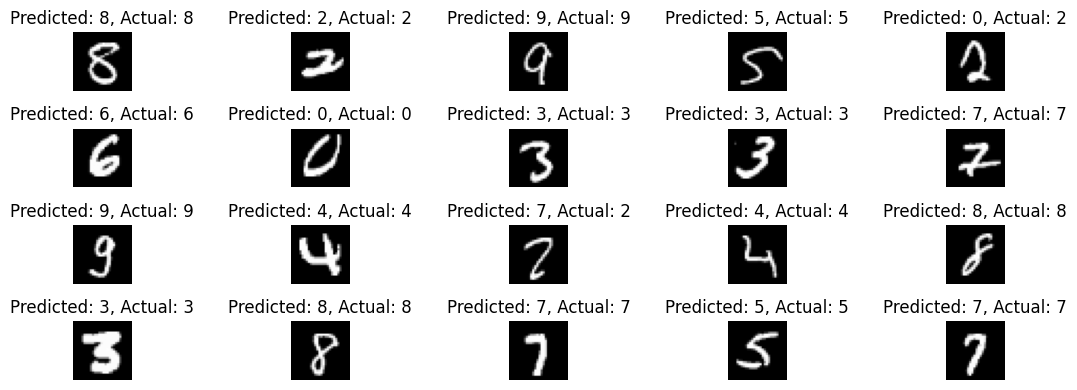

In [15]:
#  Visualize the Results
import matplotlib.pyplot as plt
import numpy as np
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
  outputs = model(images)
  preds = outputs.argmax(dim = 1)

plt.figure(figsize=(12, 4))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(images[i].squeeze().cpu(), cmap = "gray")
  plt.title(f"Predicted: {preds[i].item()}, Actual: {labels[i].item()}")
  plt.axis("off")

plt.tight_layout()
plt.show()